# IMDB-WIKI
##  Multi-task age and gender classification

On the original paper [DEX: Deep EXpectation of apparent age from a single image](https://www.vision.ee.ethz.ch/en/publications/papers/proceedings/eth_biwi_01229.pdf) the authors were able to display remarkable results in classifying the age of an individual based on a given image alone. 

Let see how accuracy (bad I guess), with limited resources, we can get with self-construct architecture. And not only age, we also classifying gender by using multi-task training technique.

In [1]:
import os
from six.moves import cPickle as pickle
import numpy as np
import scipy.io as sio
import datetime
from IPython.display import Image, display
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from collections import Counter
# from skimage.transform import resize

IMG_DIR = '/Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki'
MAT_FILE = '/Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/wiki.mat'

First, the labels, which was not easily obtained. The meta data is stored separately and in a .mat file. (Yes, matlab)!

The age parameter, requires us to calculate by taking the ```photo_taken``` and subtracting the ```dob```, the date of birth. Sounds easy? No ... as the dob is stored as a Matlab serial number.

Luckily we can use the ```scipy.io.loadmat``` to load the ```.mat``` file to python accessible (kind of) format. We can access the ```dob``` by some proper indexing, and convert the Matlab serial number to a usable format by using ```datetime.date.fromordinal( serial_number ).year```.

In [2]:
def reformat_date(mat_date):
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [3]:
def create_path(path):
    return os.path.join(IMG_DIR, path[0])

In [4]:
mat_struct = sio.loadmat(MAT_FILE)
mat_struct['wiki']

array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
                array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
                array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
                array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
                array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
                array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
              dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
                array(['Dettmar Cramer'], dtype='<U14'),
                array(['Marc Okrand'], dtype='<U11'), ...,
                array(['Michael Wiesinger'], dtype='<U17'),
                array(['Johann Grugger'], dtype='<U14'),
                array(['Greta Van Susteren'], dtype='<U18')

In [5]:
mat_struct = sio.loadmat(MAT_FILE)
data_set = [data[0] for data in mat_struct['wiki'][0, 0]]

keys = ['dob',
    'photo_taken',
    'full_path',
    'gender',
    'name',
    'face_location',
    'face_score',
    'second_face_score',
    'celeb_names',
    'celeb_id'
]

imdb_dict = dict(zip(keys, np.asarray(data_set)))
imdb_dict['dob'] = [reformat_date(dob) for dob in imdb_dict['dob']]
imdb_dict['full_path'] = [create_path(path) for path in imdb_dict['full_path']]

# Add 'age' key to the dictionary
imdb_dict['age'] = imdb_dict['photo_taken'] - imdb_dict['dob']

print("Dictionary created...")

Dictionary created...


The IMDB dataset has total 460,723 face images from 20,284 celebrities. 

We will ignore:
* images with more than one face
* gender is NaN
* invalid age.

As we are using only a subset of the data, and also using a self-constructed model that has a much smaller capacity, thus we need to take steps to adjust accordingly.

~~The original paper uses 101 age classes, which was appropriate for the their data set size and learning architecture. As we are only using a small subset of the data and a very simple model, the number of classes was set to 4:~~
* Young    (age < 30yrs)
* Middle   (30 <= age <45)
* Old      (45 <= age < 60)
* Very Old (60 <= age)

Another approach, 101 classes, age label from 0..100

In [6]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_sface = imdb_dict['second_face_score']

age = []
gender = []
imgs = []
current_age = np.zeros(101)
for i, sface in enumerate(raw_sface):
    if np.isnan(sface) and raw_age[i] >= 0 and raw_age[i] <= 100 and not np.isnan(raw_gender[i]):
        age_tmp = 0;
        if current_age[raw_age[i]] >= 5000:
            continue
        age.append(raw_age[i])
        gender.append(raw_gender[i])
        imgs.append(raw_path[i])
        current_age[raw_age[i]] += 1

/Users/admin/anaconda3/envs/py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Age size: 54144


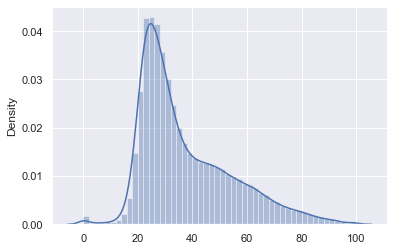

In [7]:
sns.distplot(age);
print("Age size: " + str(len(age)))

In [8]:
counter = Counter(age)
print(counter)

Counter({23: 2473, 24: 2358, 26: 2325, 25: 2288, 27: 2160, 22: 2150, 28: 2015, 29: 1846, 30: 1714, 21: 1660, 31: 1552, 32: 1435, 20: 1334, 33: 1247, 34: 1133, 35: 1027, 19: 984, 36: 983, 38: 838, 37: 831, 39: 762, 40: 758, 41: 731, 43: 712, 46: 696, 42: 694, 44: 689, 45: 684, 49: 665, 47: 660, 50: 631, 48: 628, 18: 620, 51: 606, 52: 574, 53: 565, 55: 550, 56: 514, 54: 508, 57: 494, 59: 460, 58: 448, 61: 447, 60: 442, 63: 423, 62: 400, 64: 380, 17: 359, 66: 331, 65: 328, 67: 322, 68: 308, 70: 256, 71: 247, 69: 242, 16: 240, 72: 211, 73: 204, 75: 189, 74: 186, 76: 181, 78: 166, 0: 162, 15: 157, 80: 157, 77: 145, 79: 144, 82: 131, 81: 110, 84: 106, 83: 95, 86: 83, 85: 81, 14: 74, 13: 70, 87: 70, 91: 62, 88: 60, 89: 58, 90: 51, 92: 45, 93: 38, 100: 37, 12: 37, 11: 30, 94: 26, 95: 25, 9: 25, 10: 21, 99: 18, 97: 18, 4: 17, 96: 16, 8: 16, 1: 16, 98: 15, 3: 15, 7: 14, 5: 13, 6: 13, 2: 9})


In [10]:
raw_path = imdb_dict['full_path']
raw_age = imdb_dict['age']
raw_gender = imdb_dict['gender']
raw_name = imdb_dict['name']
raw_face_location = imdb_dict['face_location']
raw_face_score = imdb_dict['face_score']
raw_second_face_score = imdb_dict['second_face_score']
# raw_celeb_names = imdb_dict['celeb_names']
# raw_celeb_id = imdb_dict['celeb_id']

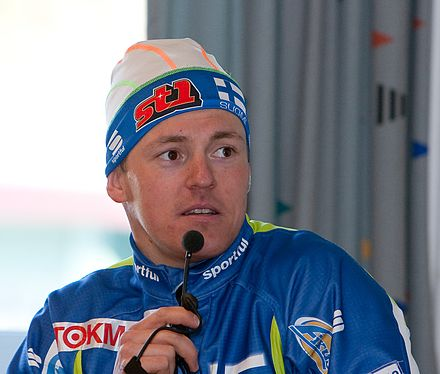

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/17/10000217_1981-05-05_2009.jpg
Age: 28
Gender: 1.0
Name: ['Sami Jauhojärvi']
Face location: [[111.29109473 111.29109473 252.66993082 252.66993082]]
Face score: 4.3009623883308095


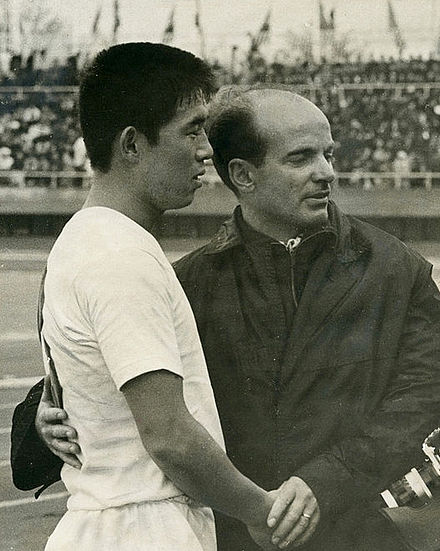

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/48/10000548_1925-04-04_1964.jpg
Age: 39
Gender: 1.0
Name: ['Dettmar Cramer']
Face location: [[252.4833023  126.68165115 354.53192596 228.73027481]]
Face score: 2.6456394971903463


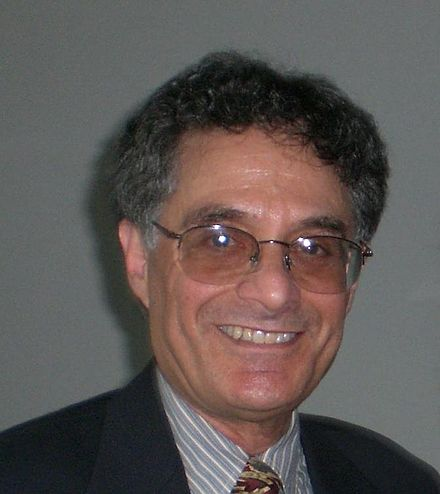

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/12/100012_1948-07-03_2008.jpg
Age: 60
Gender: 1.0
Name: ['Marc Okrand']
Face location: [[113.52 169.84 366.08 422.4 ]]
Face score: 4.329328832406529


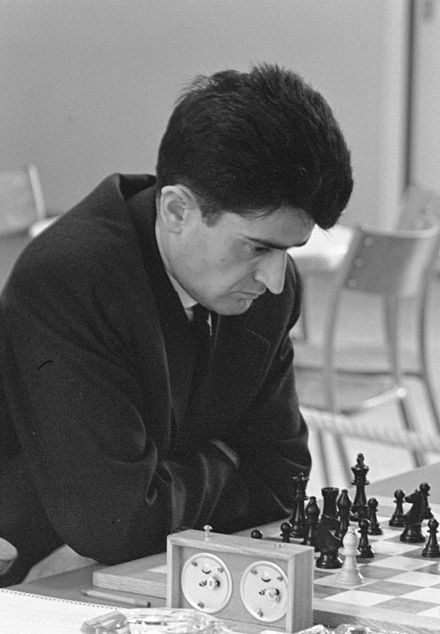

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/65/10001965_1930-05-23_1961.jpg
Age: 31
Gender: 1.0
Name: ['Aleksandar Matanović']
Face location: [[  1   1 634 440]]
Face score: -inf


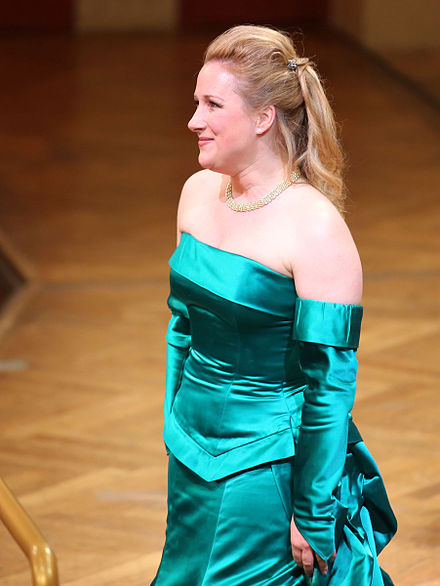

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/16/10002116_1971-05-31_2012.jpg
Age: 41
Gender: 0.0
Name: ['Diana Damrau']
Face location: [[171.61031405  75.5745124  266.76611571 170.73031405]]
Face score: 3.408442415222501


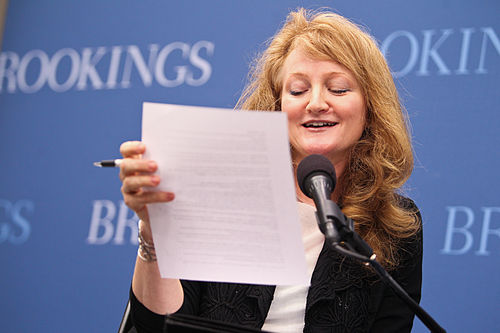

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/02/10002702_1960-11-09_2012.jpg
Age: 52
Gender: 0.0
Name: ['Krista Tippett']
Face location: [[274.7656324   57.77009008 376.88699455 159.89145224]]
Face score: 4.748056377951486


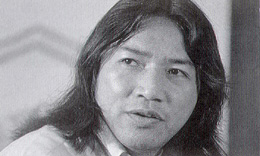

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/41/10003541_1937-09-27_1971.jpg
Age: 34
Gender: 1.0
Name: ['Bernie Whitebear']
Face location: [[ 79.35580189  26.65993396 197.60950472 144.91363679]]
Face score: 4.1848283121533445


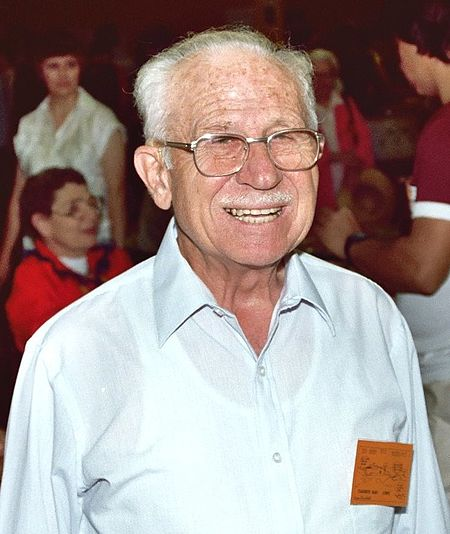

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/39/100039_1904-12-07_1982.jpg
Age: 78
Gender: 1.0
Name: ['Clarence Nash']
Face location: [[152.90731132  95.90456958 323.01553656 266.01279481]]
Face score: 3.0063501245987734


Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/13/10004113_1946-08-26_2007.jpg
Age: 61
Gender: 1.0
Name: ['William W. Destler']
Face location: [[1 1 1 1]]
Face score: -inf


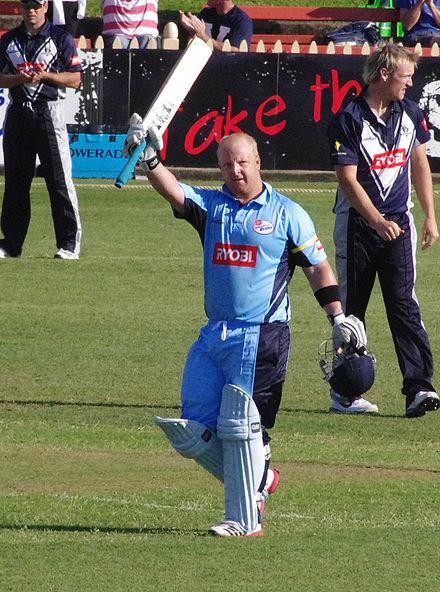

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/22/10004122_1982-03-17_2011.jpg
Age: 29
Gender: 1.0
Name: ['Daniel Smith']
Face location: [[  1   1 592 440]]
Face score: -inf


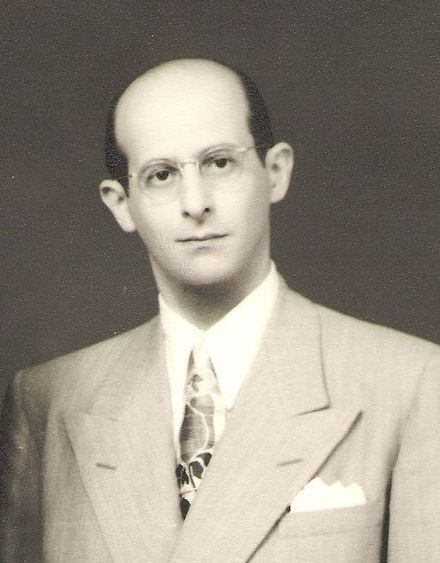

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/99/10004299_1908-08-19_1950.jpg
Age: 42
Gender: 1.0
Name: ['Carl Greenberg']
Face location: [[107.58644628 107.58644628 298.77804959 298.77804959]]
Face score: 4.526657044651478


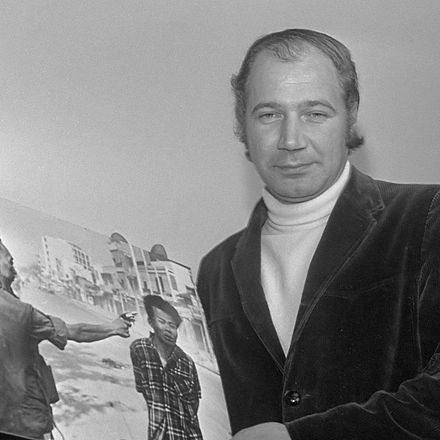

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/56/1000456_1933-06-12_1969.jpg
Age: 36
Gender: 1.0
Name: ['Eddie Adams']
Face location: [[240.24  71.28 366.08 197.12]]
Face score: 5.5518409885255


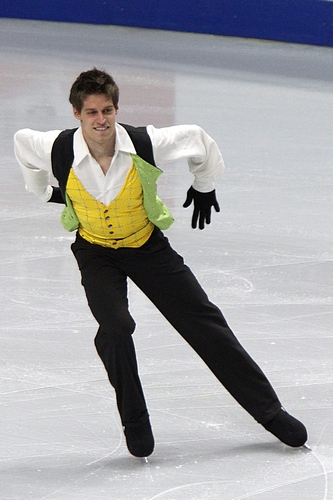

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/82/10004882_1987-05-16_2010.jpg
Age: 23
Gender: 1.0
Name: ['Viktor Pfeifer']
Face location: [[ 75.258  96.57  122.544 143.856]]
Face score: 3.9754782597283795


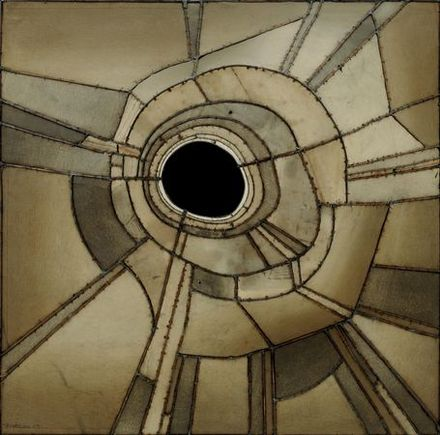

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/22/1000522_1931-01-15_1959.jpg
Age: 28
Gender: 0.0
Name: ['Lee Bontecou']
Face location: [[  1   1 435 440]]
Face score: -inf


Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/61/10005261_1936-06-24_1974.jpg
Age: 38
Gender: 1.0
Name: ['Bob Cooper']
Face location: [[1 1 1 1]]
Face score: -inf


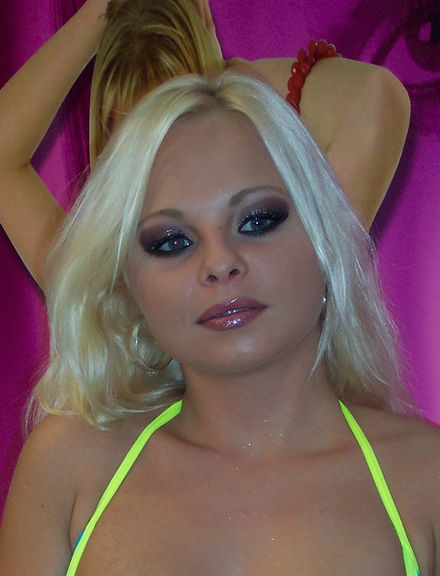

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/47/10005947_1981-04-07_2006.jpg
Age: 25
Gender: 0.0
Name: ['Sharka Blue']
Face location: [[113.52 141.68 366.08 394.24]]
Face score: 4.143016079572957


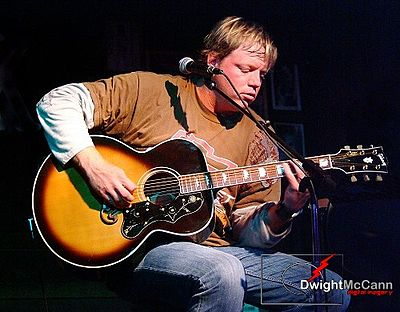

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/84/1000684_1972-04-05_2004.jpg
Age: 32
Gender: 1.0
Name: ['Pat Green']
Face location: [[221.87542481  55.9368562  276.56428101 110.62571241]]
Face score: 1.470754811661026


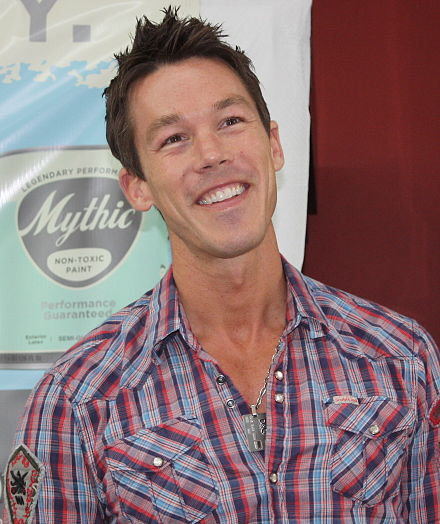

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/50/10006850_1973-08-17_2010.jpg
Age: 37
Gender: 1.0
Name: ['David Bromstad']
Face location: [[130.93069969  75.19468553 297.25874214 241.52272799]]
Face score: 3.242851859571786


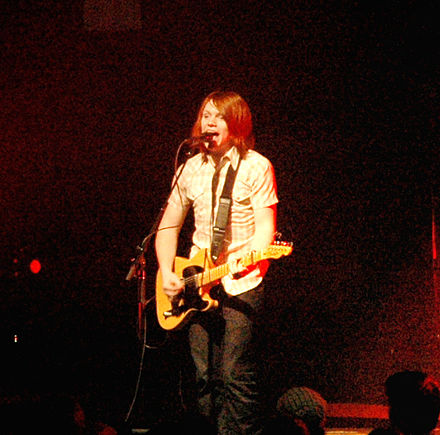

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/77/10007577_1988-06-16_2007.jpg
Age: 19
Gender: 1.0
Name: ['Leeland Dayton Mooring']
Face location: [[  1   1 435 440]]
Face score: -inf


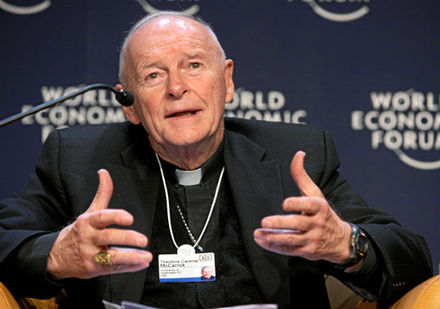

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/81/1000781_1930-07-07_2008.jpg
Age: 78
Gender: 1.0
Name: ['Theodore Edgar McCarrick']
Face location: [[126.47169334  28.58548741 251.70738669 153.82118075]]
Face score: 3.680456090252123


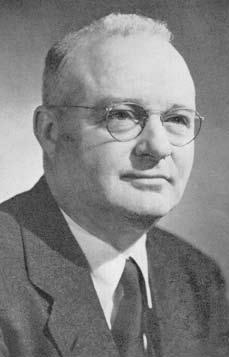

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/87/100087_1889-05-19_1940.jpg
Age: 51
Gender: 1.0
Name: ['Thomas Midgley, Jr.']
Face location: [[ 54.58895757  72.63261009 216.52383026 234.56748279]]
Face score: 2.9926363865549193


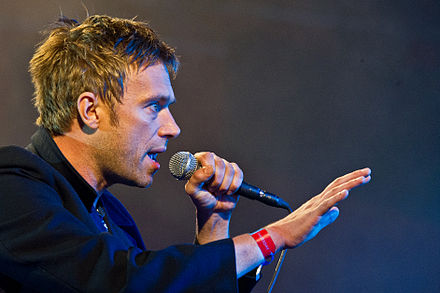

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/97/100097_1968-03-23_2010.jpg
Age: 42
Gender: 1.0
Name: ['Damon Albarn']
Face location: [[ 87.1879432   74.81623703 197.94729874 185.57559257]]
Face score: 4.297714671315127


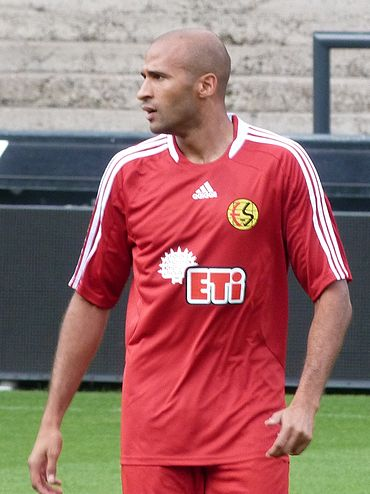

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/91/1001191_1980-11-08_2011.jpg
Age: 31
Gender: 1.0
Name: ['Diomansy Kamara']
Face location: [[126.36258903  54.57825244 206.3799677  134.59563111]]
Face score: 2.2752931504808536


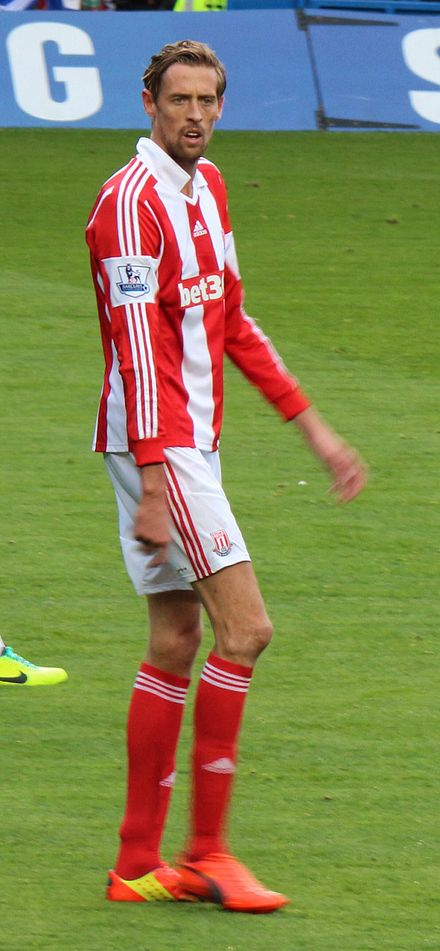

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/31/1001231_1981-01-30_2014.jpg
Age: 33
Gender: 1.0
Name: ['Peter Crouch']
Face location: [[148.22336339  78.88531003 225.34867342 156.01062006]]
Face score: 4.028333302478682


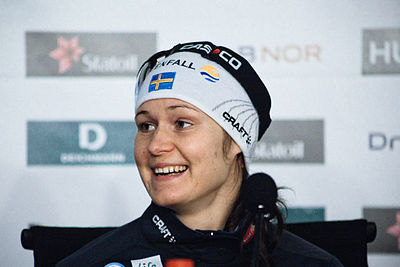

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/32/10012532_1983-03-30_2011.jpg
Age: 28
Gender: 0.0
Name: ['Britta Johansson Norgren']
Face location: [[117.0865411   91.18597641 233.1050822  207.20451751]]
Face score: 4.585282807144463


Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/85/1001285_1963-09-30_1997.jpg
Age: 34
Gender: 1.0
Name: ['Greg Williams']
Face location: [[1 1 1 1]]
Face score: -inf


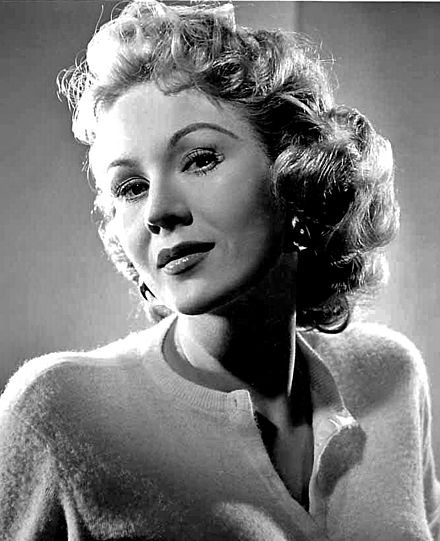

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/19/1001319_1920-11-30_1950.jpg
Age: 30
Gender: 0.0
Name: ['Virginia Mayo']
Face location: [[ 86.24515703 107.58644628 277.43676033 298.77804959]]
Face score: 2.2844780143481933


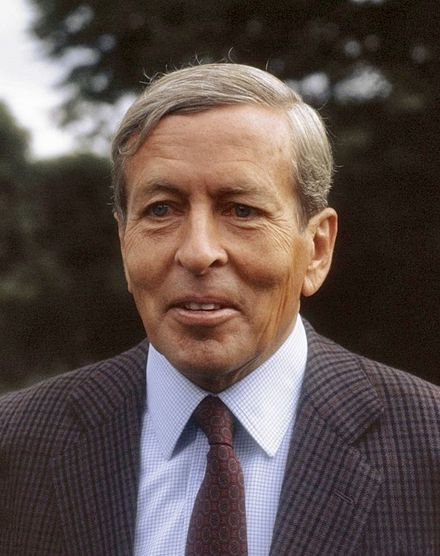

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/31/100131_1926-09-06_1986.jpg
Age: 60
Gender: 1.0
Name: ['Prince Claus of the Netherlands']
Face location: [[105.97683617 132.25104521 341.56471754 367.83892658]]
Face score: 4.902966480237615


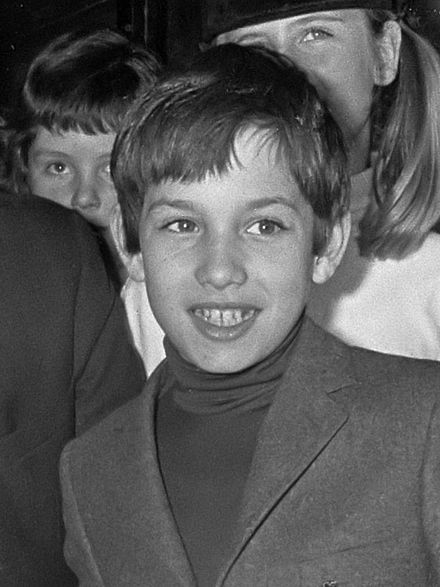

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/45/10013345_1956-05-26_1969.jpg
Age: 13
Gender: 1.0
Name: ['Mehdi El Glaoui']
Face location: [[138.11816489 160.99119237 343.09541222 365.9684397 ]]
Face score: 4.598561071814541


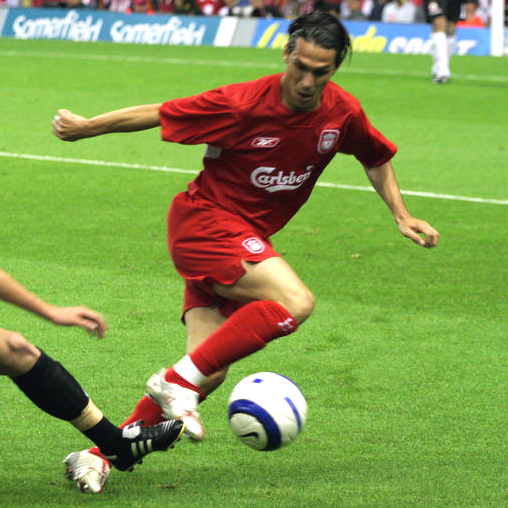

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/41/1001441_1978-06-24_2005.jpg
Age: 27
Gender: 1.0
Name: ['Luis García']
Face location: [[  1   1 508 508]]
Face score: -inf


Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/16/10014616_1991-08-12_1985.jpg
Age: -6
Gender: 1.0
Name: ['Sam Hoare']
Face location: [[1 1 1 1]]
Face score: -inf


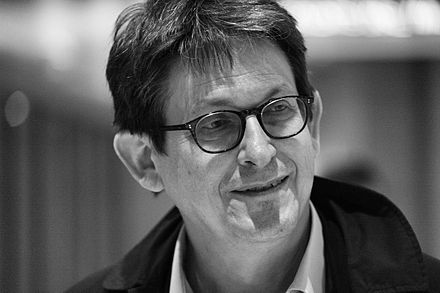

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/64/1001464_1953-12-29_2014.jpg
Age: 61
Gender: 1.0
Name: ['Alan Rusbridger']
Face location: [[129.82834932  65.20717466 323.10587329 258.48469863]]
Face score: 2.795553626934239


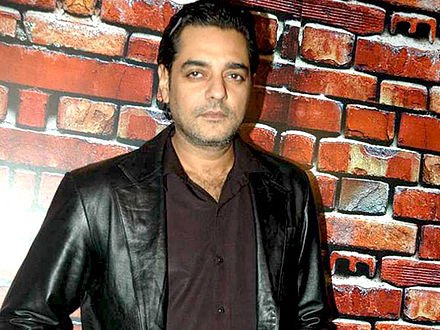

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/95/10014795_1968-10-11_2010.jpg
Age: 42
Gender: 1.0
Name: ['Chandrachur Singh']
Face location: [[159.1109887   45.93171106 260.31233858 147.13306094]]
Face score: 5.83799354555387


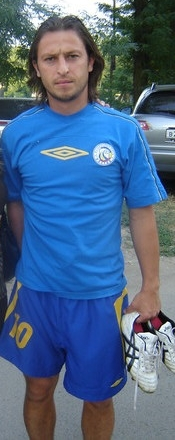

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/79/10015679_1977-03-01_2007.jpg
Age: 30
Gender: 1.0
Name: ['Maksim Buznikin']
Face location: [[38.94626473 38.94626473 96.49066182 96.49066182]]
Face score: 5.640263214902015


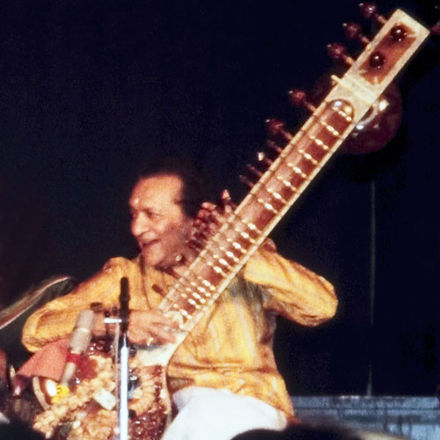

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/56/100156_1920-04-07_1988.jpg
Age: 68
Gender: 1.0
Name: ['Ravi Shankar']
Face location: [[122.22159338 191.55964674 199.34690341 268.68495677]]
Face score: 1.6432300582028034


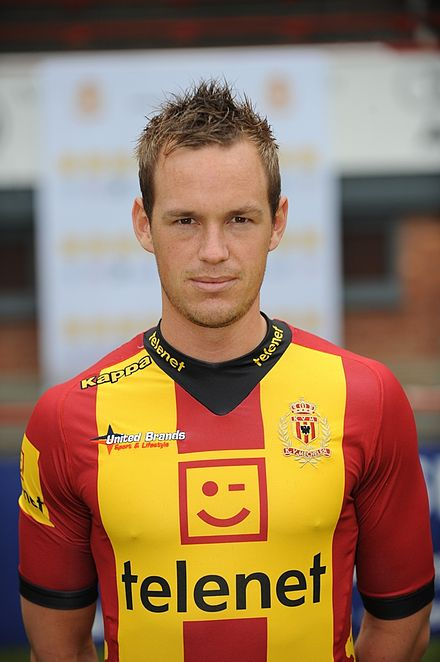

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/74/10016074_1987-07-27_2012.jpg
Age: 25
Gender: 1.0
Name: ['Thomas Enevoldsen']
Face location: [[130.26938271 178.79040122 274.95243825 323.47345677]]
Face score: 5.198935529601353


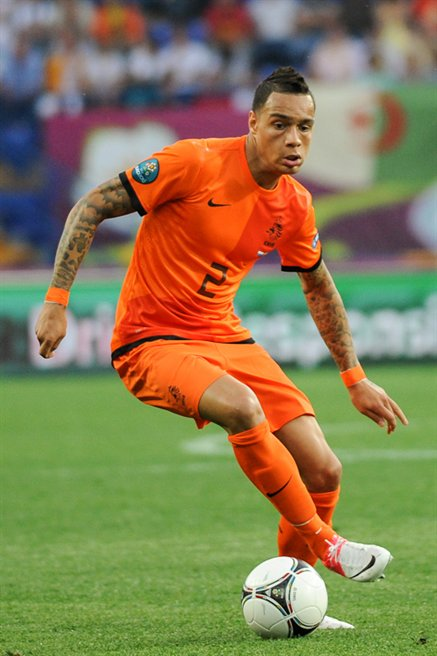

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/25/10016225_1988-02-03_2012.jpg
Age: 24
Gender: 1.0
Name: ['Gregory van der Wiel']
Face location: [[249.85666584 105.28608568 321.26795593 176.69737576]]
Face score: 3.0973002636851317


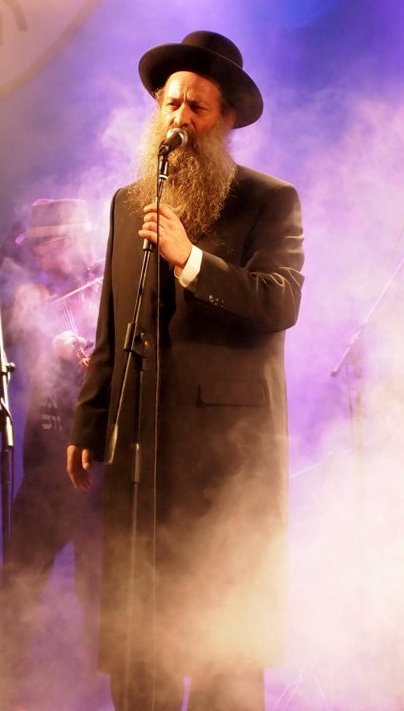

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/35/10016635_1962-02-08_2011.jpg
Age: 49
Gender: 1.0
Name: ['Shuli Rand']
Face location: [[156.21309994  83.0812882  237.67838815 164.54657641]]
Face score: 0.8834353665014355


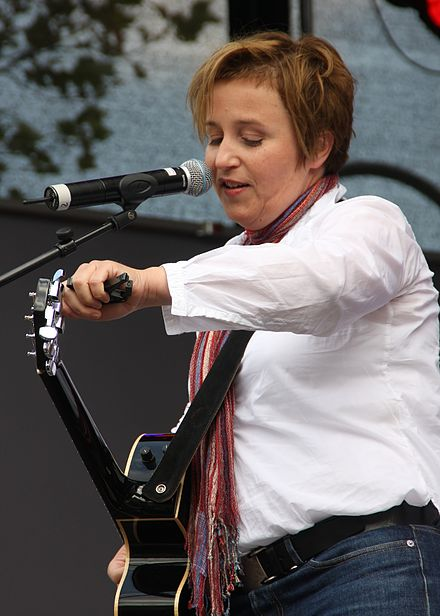

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/88/10016688_1963-07-28_2009.jpg
Age: 46
Gender: 0.0
Name: ['Katharina Franck']
Face location: [[183.92  99.44 309.76 225.28]]
Face score: 3.6644298834540887


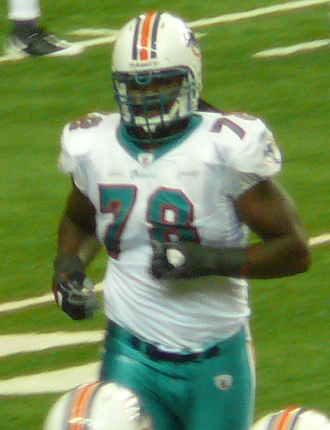

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/69/10017169_1985-01-20_2009.jpg
Age: 24
Gender: 1.0
Name: ['Tony McDaniel']
Face location: [[  1   1 430 330]]
Face score: -inf


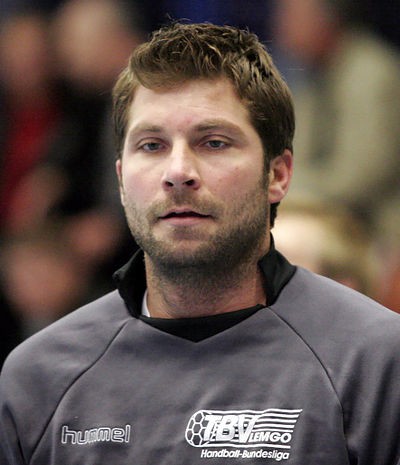

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/64/10017464_1973-08-03_2007.jpg
Age: 34
Gender: 1.0
Name: ['Daniel Stephan']
Face location: [[104.76830673  83.97464539 291.11125885 270.31759751]]
Face score: 5.343139771187023


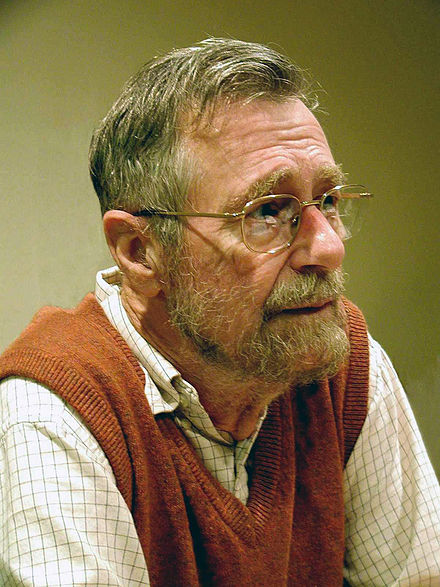

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/18/10018_1930-05-11_2002.jpg
Age: 72
Gender: 1.0
Name: ['Edsger W. Dijkstra']
Face location: [[104.88708004 104.88708004 416.02832016 416.02832016]]
Face score: 2.1200725654139307


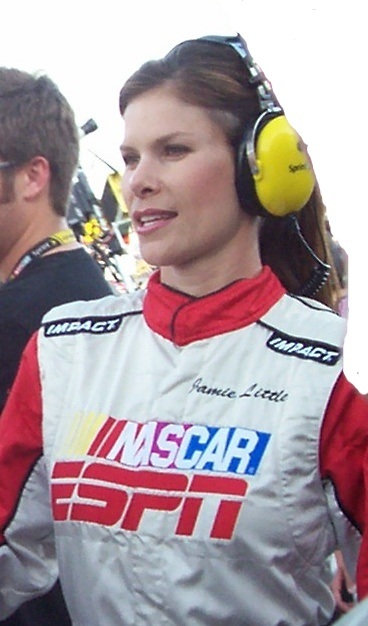

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/95/10019295_1978-04-09_2009.jpg
Age: 31
Gender: 0.0
Name: ['Jamie Little']
Face location: [[ 89.98139144 107.83046972 249.88709602 267.73617431]]
Face score: 3.660476658657166


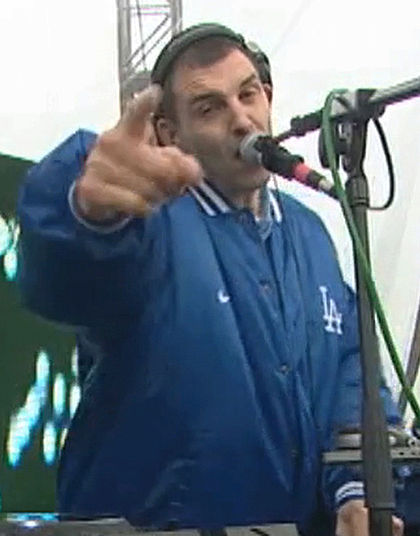

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/96/100196_1957-10-03_2010.jpg
Age: 53
Gender: 1.0
Name: ['Tim Westwood']
Face location: [[162.12  68.04 282.24 188.16]]
Face score: 1.5530068982199543


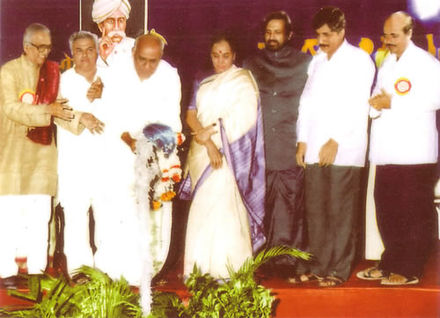

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/01/1002001_1944-05-01_1995.jpg
Age: 51
Gender: 1.0
Name: ['Suresh Kalmadi']
Face location: [[  1   1 318 440]]
Face score: -inf


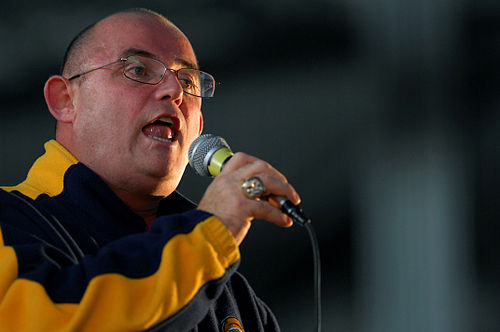

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/48/1002248_1960-05-14_2007.jpg
Age: 47
Gender: 1.0
Name: ['Ronan Tynan']
Face location: [[ 56.15637511  19.16145837 221.96950043 184.97458369]]
Face score: 2.01142503067685


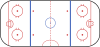

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/29/10023829_1950-04-05_1950.jpg
Age: 0
Gender: 1.0
Name: ['Butch Deadmarsh']
Face location: [[  1   1  47 100]]
Face score: -inf


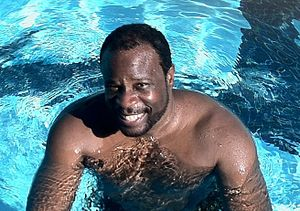

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/05/10024005_1955-12-24_2012.jpg
Age: 57
Gender: 1.0
Name: ['Grand L. Bush']
Face location: [[101.25014681  62.47009034 170.63224844 131.85219198]]
Face score: 1.6825633089862544


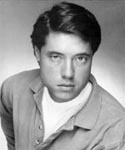

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/27/1002427_1966-05-28_2000.jpg
Age: 34
Gender: 1.0
Name: ['Luke Ford']
Face location: [[36.6271976  42.69006386 90.94299399 97.00586026]]
Face score: 4.628749123585657


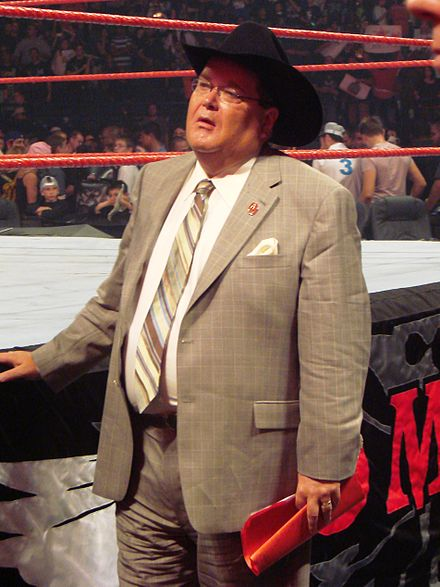

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/41/1002441_1952-01-03_2007.jpg
Age: 55
Gender: 1.0
Name: ['Jim Ross']
Face location: [[  1   1 587 440]]
Face score: -inf


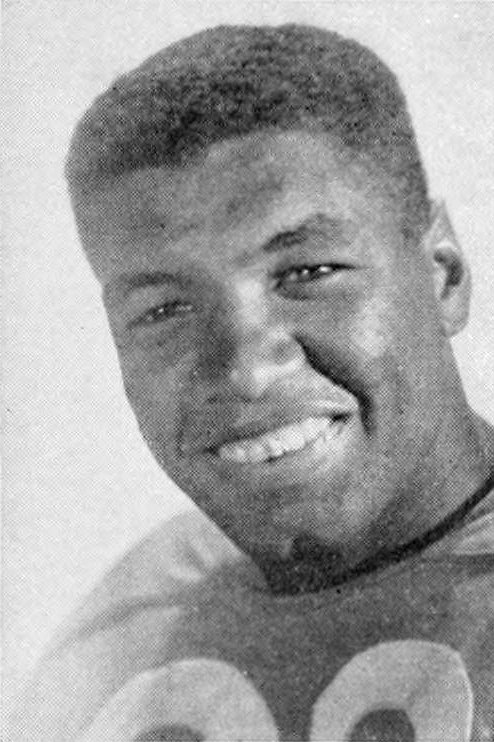

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/54/10024854_1937-11-27_1960.jpg
Age: 23
Gender: 1.0
Name: ['Marv Luster']
Face location: [[ 48.90889497 144.7506849  479.20894967 575.0507396 ]]
Face score: 2.1741090502962757


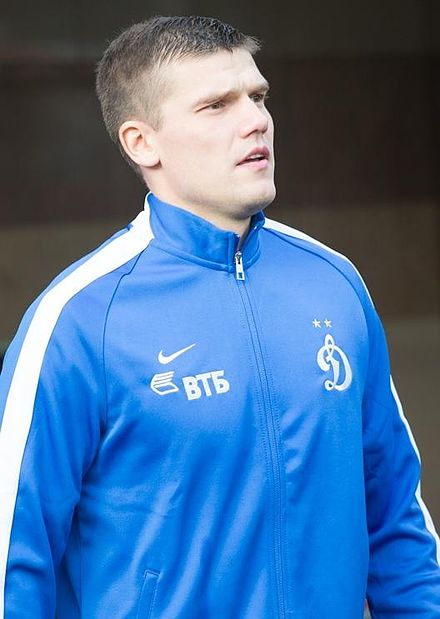

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/21/10026321_1984-05-17_2014.jpg
Age: 30
Gender: 1.0
Name: ['Igor Denisov']
Face location: [[146.44305555  65.57469135 291.12611109 210.2577469 ]]
Face score: 3.579296562259387


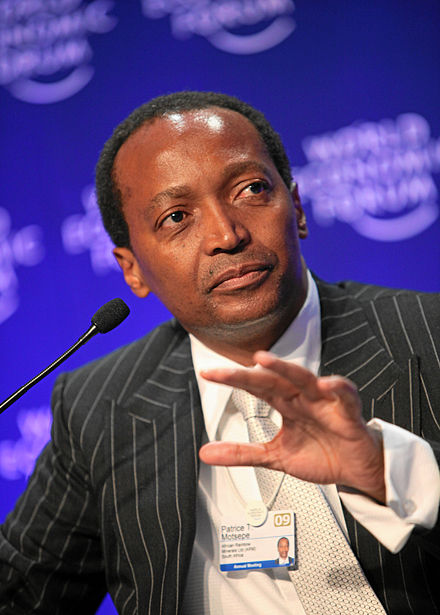

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/87/1002787_1962-01-28_2009.jpg
Age: 47
Gender: 1.0
Name: ['Patrice Motsepe']
Face location: [[138.11816489 138.11816489 343.09541222 343.09541222]]
Face score: 2.3861838105359663


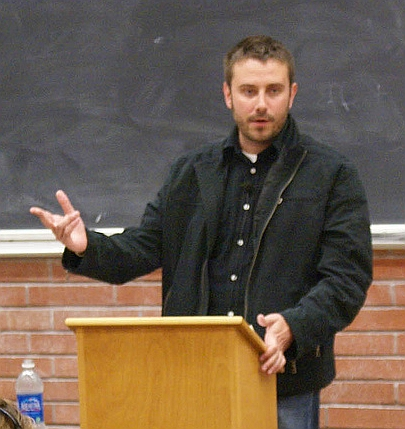

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/62/10028362_1974-10-18_2007.jpg
Age: 33
Gender: 1.0
Name: ['Jeremy Scahill']
Face location: [[214.57028155  69.21329009 290.7139829  145.35699145]]
Face score: 3.574193712293149


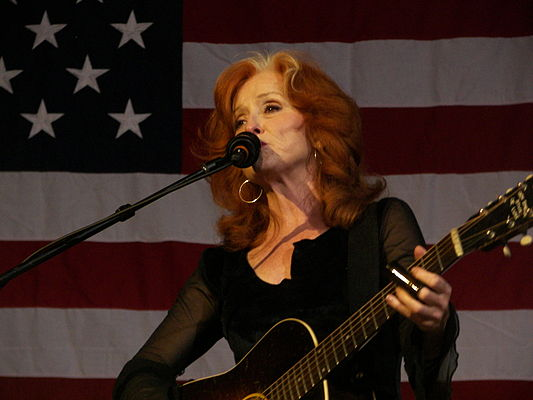

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/85/100285_1949-11-08_2007.jpg
Age: 58
Gender: 0.0
Name: ['Bonnie Raitt']
Face location: [[205.6  77.6 320.  192. ]]
Face score: 1.0887760001425466


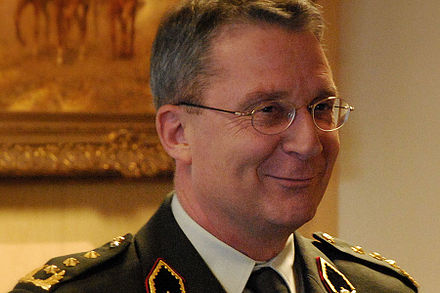

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/21/10028621_1956-10-10_2010.jpg
Age: 54
Gender: 1.0
Name: ['Ton van Loon']
Face location: [[181.46706373  60.87968791 361.76212745 241.17475163]]
Face score: 2.5018410061868983


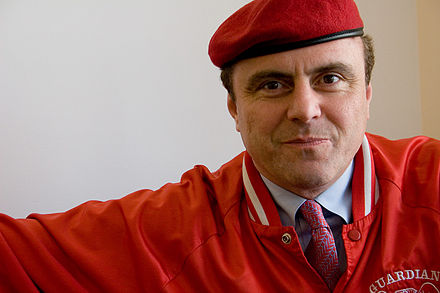

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/71/1002871_1954-03-26_2007.jpg
Age: 53
Gender: 1.0
Name: ['Curtis Sliwa']
Face location: [[245.45446244  33.23512833 391.78953991 179.57020579]]
Face score: 3.235915119442618


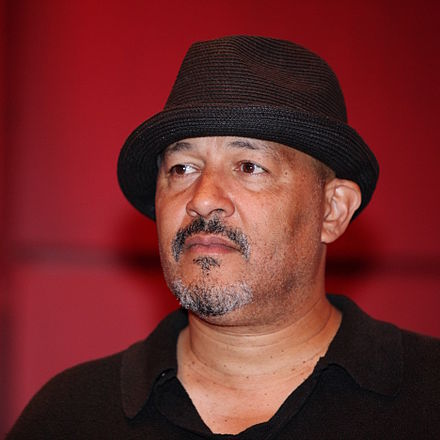

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/23/1002923_1954-09-10_2009.jpg
Age: 55
Gender: 1.0
Name: ['Clark Johnson']
Face location: [[140.26488871 120.35276175 318.59403133 298.68190437]]
Face score: 2.4973015435278874


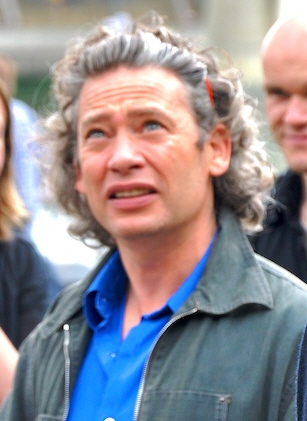

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/80/1002980_1966-01-31_2012.jpg
Age: 46
Gender: 1.0
Name: ['Dexter Fletcher']
Face location: [[ 69.03230987  86.13688734 222.35950708 239.46408455]]
Face score: 4.956032345809338


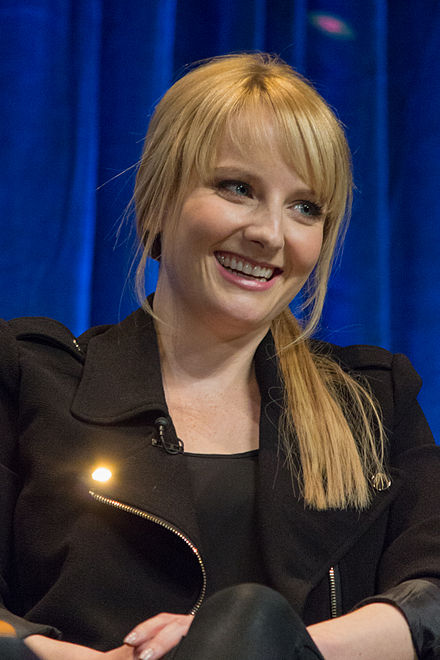

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/13/10030613_1980-06-23_2013.jpg
Age: 33
Gender: 0.0
Name: ['Melissa Rauch']
Face location: [[160.17701567 140.26488871 338.50615829 318.59403133]]
Face score: 3.3197362746058414


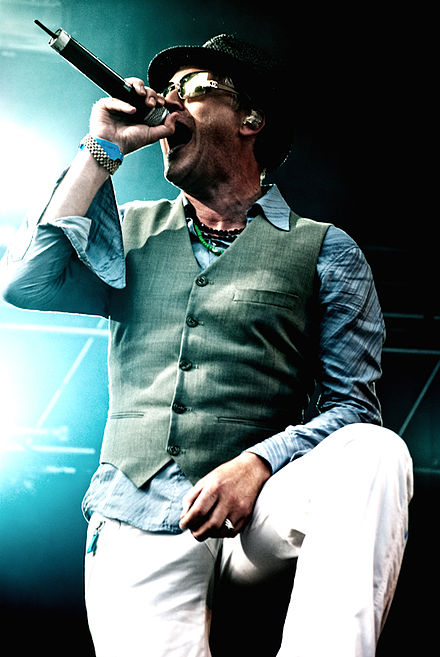

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/26/10031026_1962-10-15_2009.jpg
Age: 47
Gender: 1.0
Name: ['Morten Abel']
Face location: [[  1   1 657 440]]
Face score: -inf


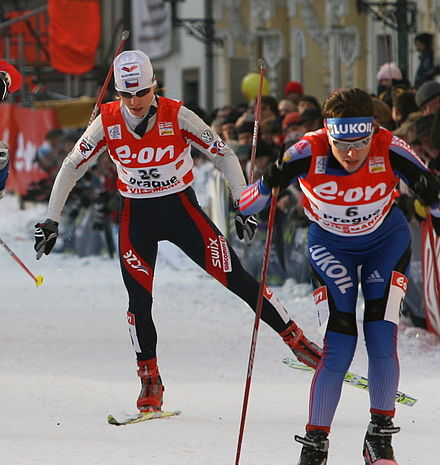

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/74/10031874_1979-02-06_2007.jpg
Age: 28
Gender: 0.0
Name: ['Helena Erbenová']
Face location: [[  1   1 465 440]]
Face score: -inf


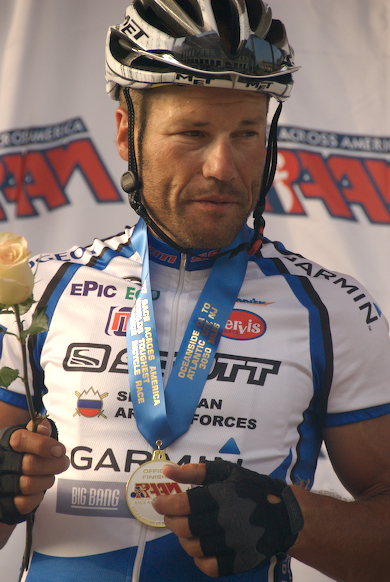

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/43/1003243_1965-04-10_2007.jpg
Age: 42
Gender: 1.0
Name: ['Jure Robič']
Face location: [[124.32569681  89.02692629 282.39016413 247.09139362]]
Face score: 4.004869221818018


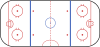

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/07/10033207_1955-01-09_1950.jpg
Age: -5
Gender: 1.0
Name: ['Ken Breitenbach']
Face location: [[  1   1  47 100]]
Face score: -inf


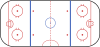

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/19/10033319_1946-09-11_1940.jpg
Age: -6
Gender: 1.0
Name: ['Mike Byers']
Face location: [[  1   1  47 100]]
Face score: -inf


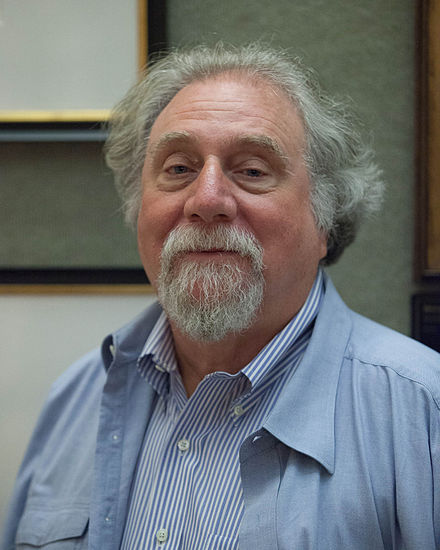

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/59/10033359_1945-06-14_2012.jpg
Age: 67
Gender: 1.0
Name: ['Bruce Degen']
Face location: [[123.45351931  98.93881545 343.20585407 318.69115021]]
Face score: 4.112617691089812


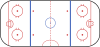

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/23/10033423_1965-06-21_1960.jpg
Age: -5
Gender: 1.0
Name: ['Paul Brydges']
Face location: [[  1   1  47 100]]
Face score: -inf


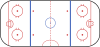

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/80/10033580_1954-10-29_1950.jpg
Age: -4
Gender: 1.0
Name: ['Mike Boland']
Face location: [[  1   1  47 100]]
Face score: -inf


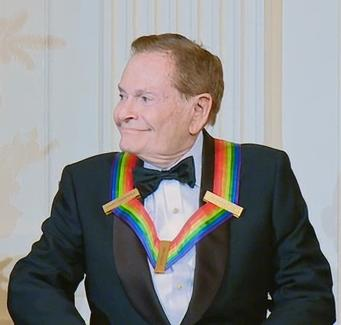

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/39/100339_1931-07-10_2010.jpg
Age: 79
Gender: 1.0
Name: ['Jerry Herman']
Face location: [[ 96.22170314  60.38231446 203.08986916 167.25048049]]
Face score: 2.809603118022331


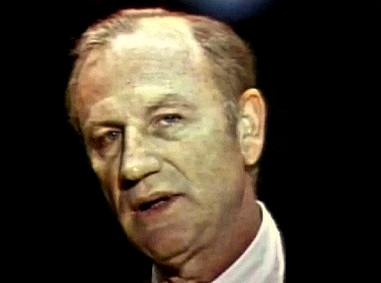

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/49/1003449_1920-08-10_1970.jpg
Age: 50
Gender: 1.0
Name: ['Red Holzman']
Face location: [[ 62.98167382  62.98167382 249.66269527 249.66269527]]
Face score: 4.028829034269829


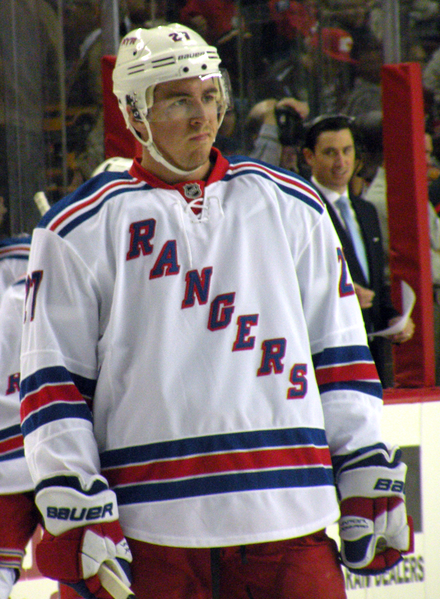

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/85/10034585_1989-06-13_2011.jpg
Age: 22
Gender: 1.0
Name: ['Ryan McDonagh']
Face location: [[  1   1 599 440]]
Face score: -inf


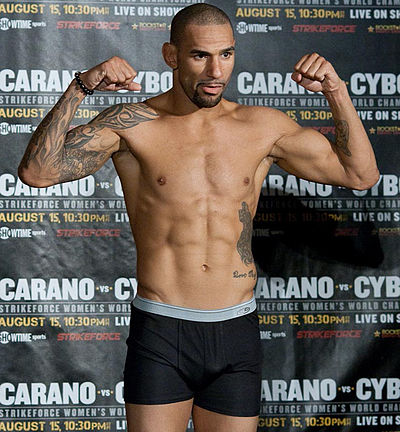

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/29/10034929_1976-07-29_2009.jpg
Age: 33
Gender: 1.0
Name: ['Jay Hieron']
Face location: [[169.69701258  34.57940252 244.90066824 109.78305818]]
Face score: 3.041627137600959


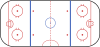

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/79/10035379_1952-01-30_1950.jpg
Age: -2
Gender: 1.0
Name: ['Larry Carriere']
Face location: [[  1   1  47 100]]
Face score: -inf


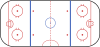

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/05/10035505_1968-09-03_1960.jpg
Age: -8
Gender: 1.0
Name: ['Rob Conn']
Face location: [[  1   1  47 100]]
Face score: -inf


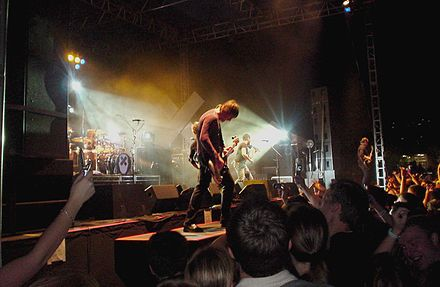

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/47/10036447_1980-06-06_2006.jpg
Age: 26
Gender: 1.0
Name: ['Peter Mosely']
Face location: [[  1   1 287 440]]
Face score: -inf


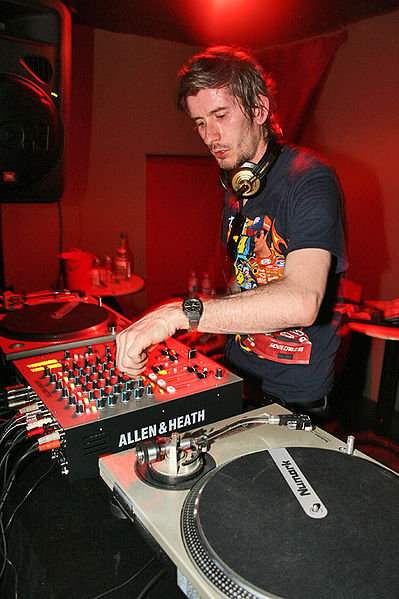

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/34/10038134_1975-07-31_2007.jpg
Age: 32
Gender: 1.0
Name: ['Kavinsky']
Face location: [[190.39312703  91.08139382 270.85018147 171.53844826]]
Face score: 1.7507017270197


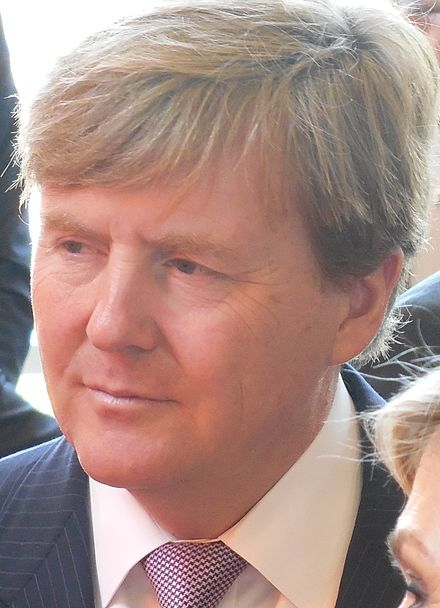

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/84/100384_1967-04-27_2015.jpg
Age: 48
Gender: 1.0
Name: ['Willem-Alexander of the Netherlands']
Face location: [[  0.88       160.17701567 358.41828525 517.71530091]]
Face score: 4.23657431912644


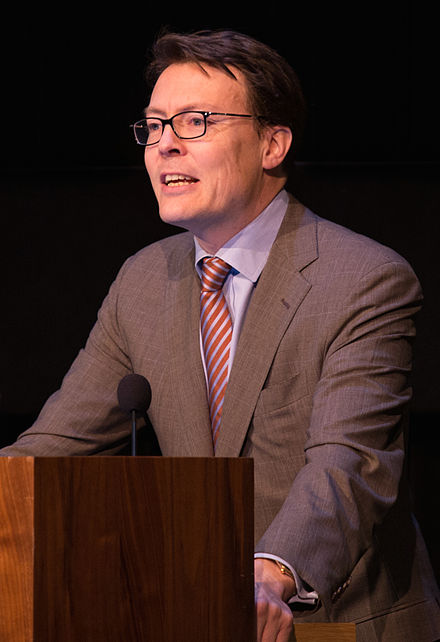

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/87/100387_1969-10-11_2013.jpg
Age: 44
Gender: 1.0
Name: ['Prince Constantijn of the Netherlands']
Face location: [[112.3520283   75.19468553 278.68007076 241.52272799]]
Face score: 3.2980966439990085


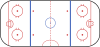

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/55/10038855_1962-04-05_1960.jpg
Age: -2
Gender: 1.0
Name: ['Gord Donnelly']
Face location: [[  1   1  47 100]]
Face score: -inf


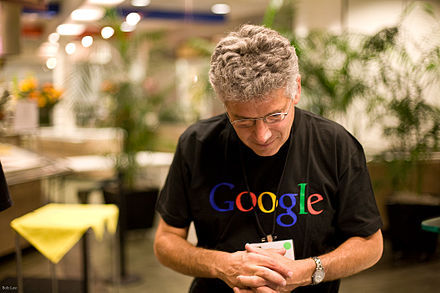

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/38/10038938_1961-08-28_2008.jpg
Age: 47
Gender: 1.0
Name: ['Joshua Bloch']
Face location: [[225.61   94.346 309.408 178.144]]
Face score: 0.8756134873962859


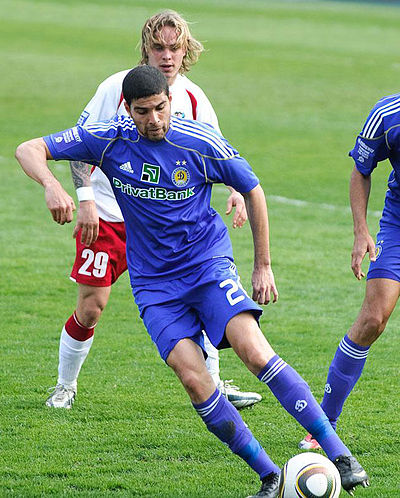

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/63/10039063_1985-06-13_2010.jpg
Age: 25
Gender: 1.0
Name: ['Gérson Magrão']
Face location: [[  1   1 498 400]]
Face score: -inf


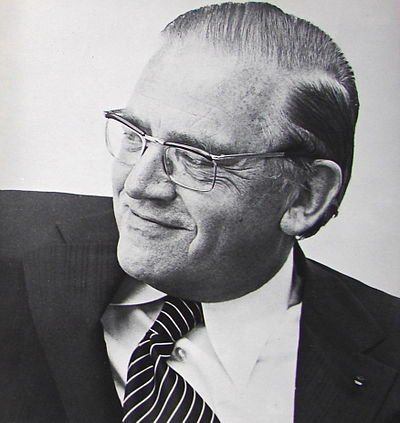

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/23/10039123_1913-12-03_1976.jpg
Age: 63
Gender: 1.0
Name: ['Omer Vanaudenhove']
Face location: [[ 77.6  77.6 307.2 307.2]]
Face score: 2.055348433710995


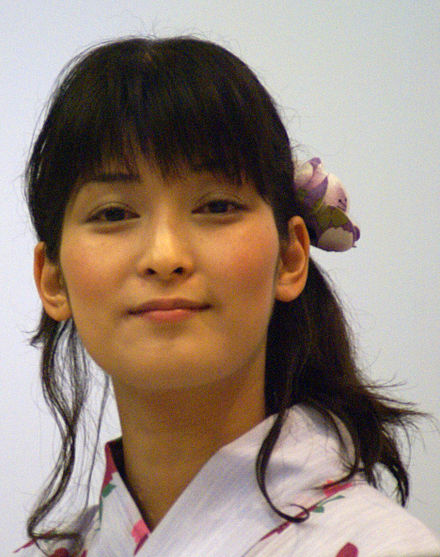

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/48/1003948_1976-03-30_2006.jpg
Age: 30
Gender: 0.0
Name: ['Ayako Kawasumi']
Face location: [[ 29.04 141.68 281.6  394.24]]
Face score: 3.4625193832524364


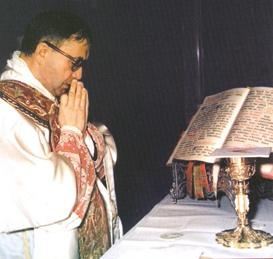

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/97/100397_1902-01-09_2003.jpg
Age: 101
Gender: 1.0
Name: ['Josemaría Escrivá']
Face location: [[  1   1 259 273]]
Face score: -inf


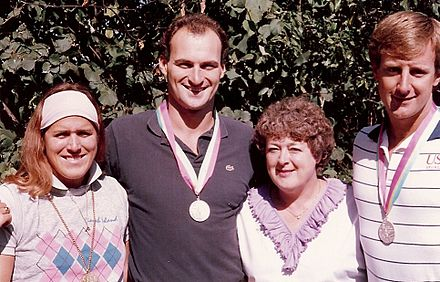

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/61/10040161_1955-10-19_1984.jpg
Age: 29
Gender: 1.0
Name: ['Andrew McDonald']
Face location: [[ 31.98739313 110.54587596 102.12602768 180.68451051]]
Face score: 4.302474466933985


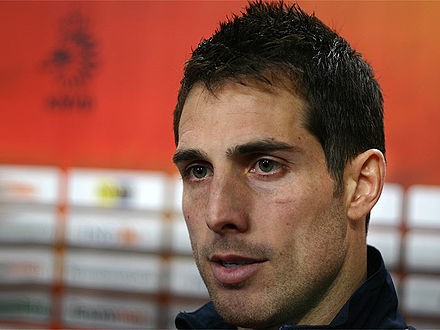

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/27/1004027_1979-05-25_2010.jpg
Age: 31
Gender: 1.0
Name: ['Carlos Bocanegra']
Face location: [[146.22305555  97.70203703 363.90763886 315.38662035]]
Face score: 3.7821766639207466


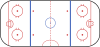

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/82/10040382_1962-12-01_1960.jpg
Age: -2
Gender: 1.0
Name: ['Steve Dykstra']
Face location: [[  1   1  47 100]]
Face score: -inf


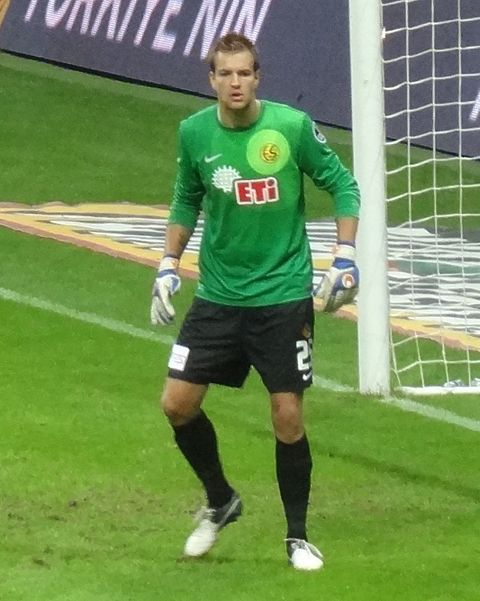

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/19/10040419_1987-11-05_2012.jpg
Age: 25
Gender: 1.0
Name: ['Ruud Boffin']
Face location: [[208.32  54.72 276.48 122.88]]
Face score: 0.9608092537803354


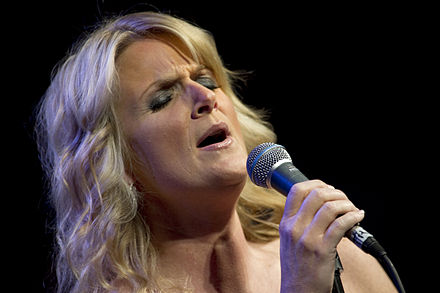

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/59/1004059_1964-09-19_2010.jpg
Age: 46
Gender: 0.0
Name: ['Trisha Yearwood']
Face location: [[107.20549856  46.28007081 243.70171098 182.77628324]]
Face score: 1.4593627896277757


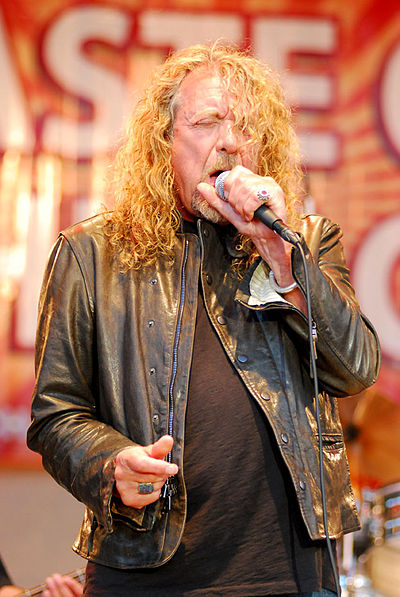

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/05/100405_1948-08-20_2010.jpg
Age: 62
Gender: 1.0
Name: ['Robert Plant']
Face location: [[154.4  90.4 268.8 204.8]]
Face score: 1.6996363424278569


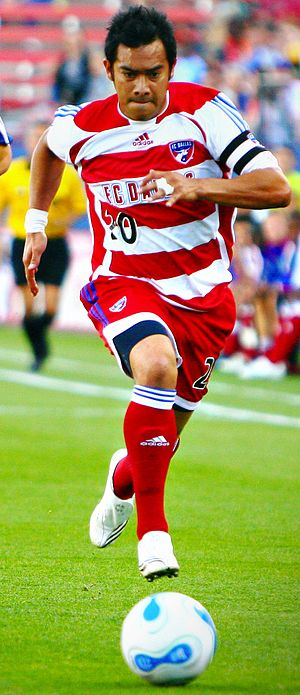

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/78/1004078_1979-09-15_2007.jpg
Age: 28
Gender: 1.0
Name: ['Carlos Ruiz']
Face location: [[102.45615327  51.52807663 167.33510894 116.40703231]]
Face score: 1.8459519360248207


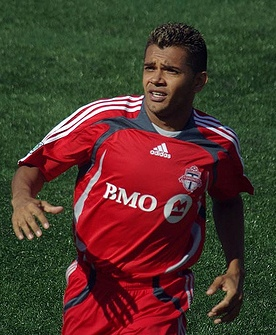

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/07/1004107_1976-05-02_2008.jpg
Age: 32
Gender: 1.0
Name: ['Amado Guevara']
Face location: [[136.85445013  50.76869215 200.86676861 114.78101063]]
Face score: 1.7885053363311725


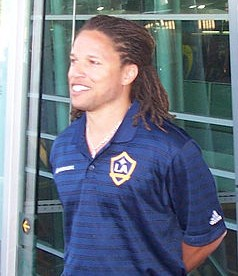

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/60/1004160_1970-06-16_2007.jpg
Age: 37
Gender: 1.0
Name: ['Cobi Jones']
Face location: [[ 52.96692003  35.46994669 131.22730007 113.73032673]]
Face score: 3.0912951031731306


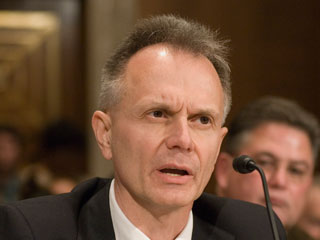

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/78/10043078_1954-03-18_2006.jpg
Age: 52
Gender: 1.0
Name: ['David Deming']
Face location: [[ 92.64  77.28 230.4  215.04]]
Face score: 4.796005743921171


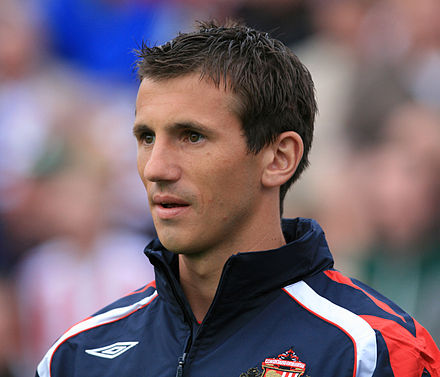

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/29/1004429_1981-02-13_2007.jpg
Age: 26
Gender: 1.0
Name: ['Liam Miller']
Face location: [[110.46762795  92.18202329 274.28406988 255.99846522]]
Face score: 4.597932586281533


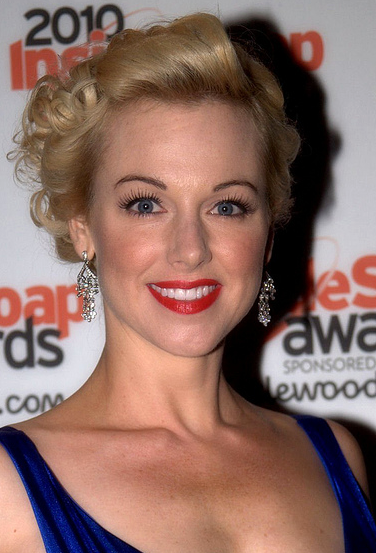

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/40/1004540_1975-08-25_2011.jpg
Age: 36
Gender: 0.0
Name: ['Sarah Manners']
Face location: [[ 52.3343132  129.70778301 283.70272263 361.07619243]]
Face score: 5.244717610419388


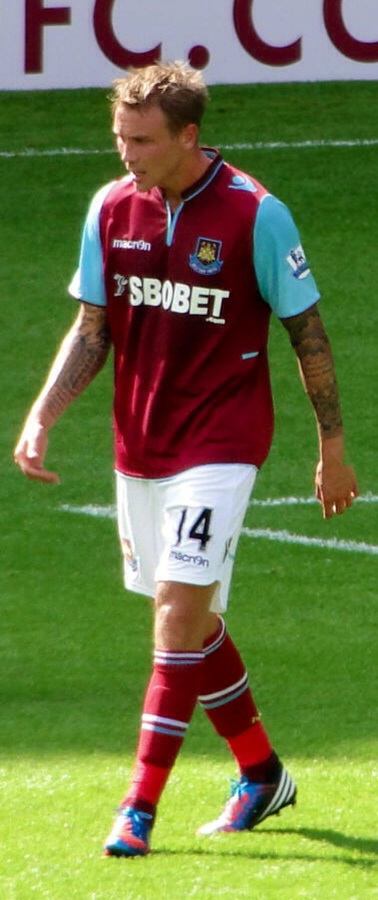

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/04/1004604_1981-11-27_2012.jpg
Age: 31
Gender: 1.0
Name: ['Matthew Taylor']
Face location: [[110.76064553 119.92769933 192.50812968 201.67518347]]
Face score: 1.2124626459715249


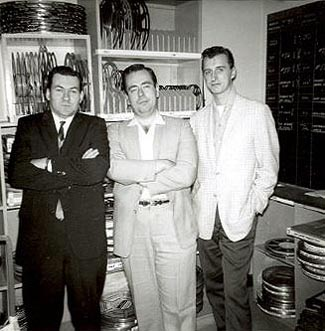

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/06/10046706_1933-04-21_1962.jpg
Age: 29
Gender: 1.0
Name: ['Jim Harmon']
Face location: [[ 42.25  73.45  88.4  119.6 ]]
Face score: 1.6393847455655444


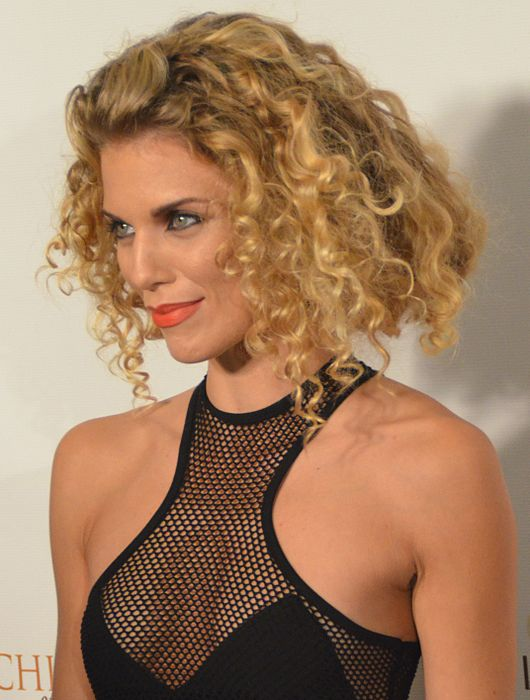

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/56/10046756_1987-07-16_2014.jpg
Age: 27
Gender: 0.0
Name: ['AnnaLynne McCord']
Face location: [[ 79.79324245 178.28479552 256.07803798 354.56959104]]
Face score: 2.831632070596439


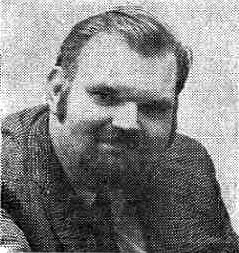

Path: /Users/admin/Development/Dev/ComputerVision/SmileDetection/wiki/87/10047987_1940-05-15_1969.jpg
Age: 29
Gender: 1.0
Name: ['John Verpoorten']
Face location: [[  1   1 253 239]]
Face score: -inf


In [11]:
for i in range(100):
    display(Image(filename=raw_path[i]))
    print("Path: " + str(raw_path[i]))
    print("Age: " + str(raw_age[i]))
    print("Gender: " + str(raw_gender[i]))
    print("Name: " + str(raw_name[i]))
    print("Face location: " + str(raw_face_location[i]))
    print("Face score: " + str(raw_face_score[i]))
    # print("Second face score: " + str(raw_second_face_score[i]))
    # print("Celeb id: " + str(raw_celeb_id[i])+"\n")
    
    